# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
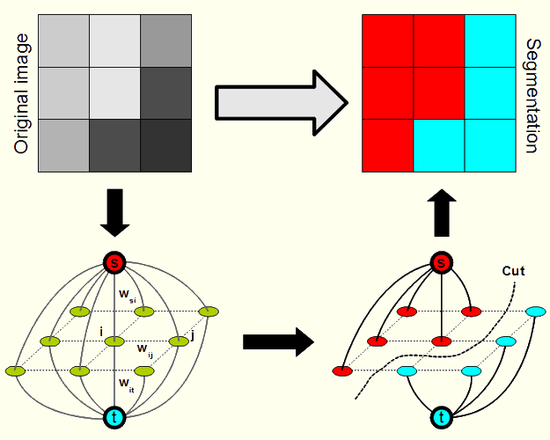

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [ ]:
! pip install sklearn
! pip install python-igraph
! pip install opencv-contrib-python
! pip install matplotlib

In [2]:
import numpy as np
import sys, cv2
from sklearn.mixture import GaussianMixture
from igraph import Graph
import matplotlib.pyplot as plt

In [3]:
def createGraphWoGMMedges(mask, nodes, pixels, gamma):
    edges = []
    weights = []
    # Vertical edges
    for i in range(nodes.shape[0]-1):
        for j in range(nodes.shape[1]):
            edges.append([nodes[i][j], nodes[i+1][j]])
            weights.append(np.sum(pixels[i][j] - pixels[i+1][j])**2)
    # Horizontal edges
    for i in range(nodes.shape[0]):
        for j in range(nodes.shape[1]-1):
            edges.append([nodes[i][j], nodes[i][j+1]])
            weights.append(np.sum(pixels[i][j] - pixels[i][j+1])**2)
    # top-left to bottom-right edges
    for i in range(nodes.shape[0]-1):
        for j in range(nodes.shape[1]-1):
            edges.append([nodes[i][j], nodes[i+1][j+1]])
            weights.append((np.sum(pixels[i][j] - pixels[i+1][j+1])**2) / np.sqrt(2))
    # top-right to bottom-left edges
    for i in range(nodes.shape[0]-1):
        for j in range(1, nodes.shape[1]):
            edges.append([nodes[i][j], nodes[i+1][j-1]])
            weights.append((np.sum(pixels[i][j] - pixels[i+1][j-1])**2) / np.sqrt(2))

    edges = np.array(edges)
    weights = np.array(weights)

    xLen, yLen, _ = pixels.shape
    b = yLen*(xLen - 1) + (yLen - 1)*xLen + 2*(yLen - 1)*(xLen - 1)
    b = 1/(2*np.sum(weights)/b)
    weights = (gamma * np.exp(-b * weights)).reshape(-1, 1)

    # find node ids of BG/NotAssigned nodes
    bgNodes = nodes[mask==0].reshape(-1, 1)
    naNodes = nodes[mask==1].reshape(-1, 1)
    
    # add background edges to source nodes with weight = 0
    edges = np.concatenate((edges, np.concatenate((bgNodes, \
        np.full(bgNodes.shape[0], xLen * yLen).reshape(-1, 1)), \
        axis=1)), axis=0)
    weights = np.concatenate((weights, np.zeros((bgNodes.shape[0], 1))), axis=0)

    # add background edges to terminal nodes with weight = inf
    edges = np.concatenate((edges, np.concatenate((bgNodes, \
        np.full(bgNodes.shape[0], xLen * yLen + 1).reshape(-1, 1)), \
        axis=1)), axis=0)
    weights = np.concatenate((weights, 9 * gamma * np.ones((bgNodes.shape[0], 1))), axis=0)
        
    return edges, weights, bgNodes, naNodes

def getEdgesWeightsGMM(edges, weights, naNodes, img, backGMM, foreGMM):
    xLen, yLen, _ = img.shape
    # for each node x add edge with source with weight given by GMM
    tmpNodes = np.full(naNodes.shape[0], xLen * yLen).reshape(-1, 1)
    tmpNodes = np.concatenate((naNodes, tmpNodes), axis=1)
    tmpWeights = -backGMM.score_samples(img.reshape([xLen * yLen, 3])[naNodes].reshape(-1, 3)).reshape(-1, 1)
    currEdges = np.concatenate((edges, tmpNodes), axis=0)
    currWeights = np.concatenate((weights, tmpWeights), axis=0)

    # for each node x add edge with sink with weight given by GMM
    tmpNodes = np.full(naNodes.shape[0], xLen * yLen + 1).reshape(-1, 1)
    tmpNodes = np.concatenate((naNodes, tmpNodes), axis=1)
    tmpWeights = -foreGMM.score_samples(img.reshape([xLen*yLen, 3])[naNodes].reshape(-1, 3)).reshape(-1, 1)
    currEdges = np.concatenate((currEdges, tmpNodes), axis=0).astype(np.int)
    currWeights = np.concatenate((currWeights, tmpWeights), axis=0)

    return currEdges, currWeights

def getNewNodes(graph, xLen, yLen):
    # Apply minCut on graph
    minCut = graph.mincut(xLen * yLen, xLen * yLen + 1, capacity='weight')
    x = np.array(minCut[1])
    y = np.array(minCut[0])
    # Return node ids except source and sink
    return x[x < xLen * yLen], y[y < xLen * yLen]

def grabCut(img, rect, mask, gamma, its=1, k=5):

    sys.stdout.write("\rStarting Grabcut...")
    sys.stdout.flush()

    if its == 0:
        return mask

    rect[2] += rect[0]
    rect[3] += rect[1]
    # Remove everything outside bounding box (i.e. Make BG)
    mask[rect[3]+1:, :] = 0
    mask[:rect[1]-1, :] = 0
    mask[:, :rect[0]-1] = 0
    mask[:, rect[2]+1:] = 0

    yLen, xLen, _ = img.shape
    nodes = np.arange(xLen * yLen).reshape(yLen, xLen)
    edges, weights, bgNodes, naNodes = createGraphWoGMMedges(mask, nodes, img, gamma)
    
    currFgNodes = naNodes.copy()
        
    # Initialize GMM with k components
    foreGMM = GaussianMixture(n_components=k)
    backGMM = GaussianMixture(n_components=k)

    for i in range(its):

        sys.stdout.write("\rIteration = " + str(i + 1) + "...")
        sys.stdout.flush()

        # Initialize graph and add nodes
        graph = Graph()
        graph.add_vertices(yLen * xLen + 2)

        # Relearn GMMs
        foreGMM.fit(img.reshape([xLen*yLen, 3])[currFgNodes].reshape(-1, 3))
        backGMM.fit(img.reshape([xLen*yLen, 3])[bgNodes].reshape(-1, 3))

        # Get the edges and weights from GMM to add to the source and sink
        currEdges, currWeights = getEdgesWeightsGMM(edges, weights, naNodes, img, backGMM, foreGMM)

        # Add edges and weights to graph
        graph.add_edges(currEdges)
        graph.es['weight'] = currWeights.flatten()

        # find minCut and get the FG/BG nodes
        bgNodes, currFgNodes = getNewNodes(graph, xLen, yLen)
        
        # Make binary mask
        mask = np.ones(yLen * xLen, np.uint8) 
        mask[bgNodes] = 0
        mask = mask.reshape([yLen, xLen])
    
    sys.stdout.write("\rGrabcut Ended...")
    sys.stdout.flush()
    return mask, graph, currEdges, currWeights.flatten()

def refineCut(maskFg, maskBg, graph, edges, weights, gamma):
    sys.stdout.write("\rRefining...")
    sys.stdout.flush()
    yLen, xLen = maskFg.shape
    nodes = np.arange(yLen * xLen).reshape(yLen, xLen)
    # Find FG and BG nodes
    sureFg = nodes[maskFg==1].reshape(-1, 1)
    sureBg = nodes[maskBg==0].reshape(-1, 1)
    sureFg1 = np.hstack((sureFg, np.full(len(sureFg), \
                yLen * xLen).reshape(-1, 1)))
    sureFg2 = np.hstack((sureFg, np.full(len(sureFg), \
                yLen * xLen + 1).reshape(-1, 1)))
    sureBg1 = np.hstack((sureBg, np.full(len(sureBg), \
                yLen * xLen).reshape(-1, 1)))
    sureBg2 = np.hstack((sureBg, np.full(len(sureBg), \
                yLen * xLen + 1).reshape(-1, 1)))
    weightsDict = {}
    # Store weights in dictionary
    gamma *= 9
    for i in sureBg1:
        weightsDict[tuple(i)] = 0
    for i in sureBg2:
        weightsDict[tuple(i)] = gamma
    for i in sureFg1:
        weightsDict[tuple(i)] = gamma
    for i in sureFg2:
        weightsDict[tuple(i)] = 0
    # Modify weights in 'weights'
    for i in range(len(edges)):
        try:
            weightsDict[tuple(edges[i])]
            weights[i] = weightsDict[tuple(edges[i])]
        except:
            pass
    # Modify weights in graph
    graph.es['weight'] = weights
    # find minCut and get the FG/BG nodes
    bgNodes, _ = getNewNodes(graph, xLen, yLen)
    # Make binary mask
    mask = np.ones(yLen * xLen, np.uint8) 
    mask[bgNodes] = 0

    sys.stdout.write("\rRefining Done......")
    sys.stdout.flush()
    return mask.reshape([yLen, xLen])

In [4]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, _mainMask, _maskFg, _maskBg, img, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mainMask = _mainMask
        self._maskFg = _maskFg
        self._maskBg = _maskBg
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img

    @property
    def mainMask(self):
        return self._mainMask
    
    @mainMask.setter
    def mainMask(self, _mask):
        self._mainMask = _mask

    @property
    def maskFg(self):
        return self._maskFg
    
    @maskFg.setter
    def maskFg(self, _mask):
        self._maskFg = _mask

    @property
    def maskBg(self):
        return self._maskBg
    
    @maskBg.setter
    def maskBg(self, _mask):
        self._maskBg = _mask

    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                if self.FLAGS['value']['val'] == 1:
                    cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskFg, (x,y), 3, self.FLAGS['value']['val'], -1)
                else:
                    cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskBg, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mainMask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                if self.FLAGS['value']['val'] == 1:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskFg, (x, y), 3, self.FLAGS['value']['val'], -1)
                else:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskBg, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mainMask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                if self.FLAGS['value']['val'] == 1:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskFg, (x, y), 3, self.FLAGS['value']['val'], -1)
                else:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskBg, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mainMask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [5]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    mainMask = np.ones(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    maskFg = np.zeros(img.shape[:2], dtype = np.uint8)
    maskBg = np.ones(img.shape[:2], dtype = np.uint8)
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image', cv2.WINDOW_GUI_NORMAL)
    cv2.namedWindow('Segmented image')
    
    EventObj = EventHandler(FLAGS, mainMask, maskFg, maskBg, img, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)

    bboxFlag = True
    while(1):
        
        img = EventObj.image
        mainMask = EventObj.mainMask
        maskFg = EventObj.maskFg
        maskBg = EventObj.maskBg
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(100)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, img.shape[0]-1, img.shape[1]-1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mainMask = np.ones(img.shape[:2], np.uint8) 
            maskFg = np.zeros(img.shape[:2], np.uint8) 
            maskBg = np.ones(img.shape[:2], np.uint8) 
            EventObj.image = img
            EventObj.mainMask = mainMask
            EventObj.maskFg = maskFg
            EventObj.maskBg = maskBg
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            if bboxFlag:
                EventObj.mainMask, graph, edges, weights = grabCut(cv2.cvtColor(img2, \
                                                        cv2.COLOR_BGR2RGB), \
                                                        list(FLAGS['RECT']), \
                                                        mainMask, 50, its=5, k=5)
                bboxFlag = False
            else:
                EventObj.mainMask = refineCut(maskFg, maskBg, graph, edges, weights, 50)

        EventObj.flags = FLAGS
        mask2 = np.where((mainMask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

In [ ]:
if __name__ == '__main__':
    filename = '../images/llama.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

## Report

### 1) The number of mixture components in your GMM.

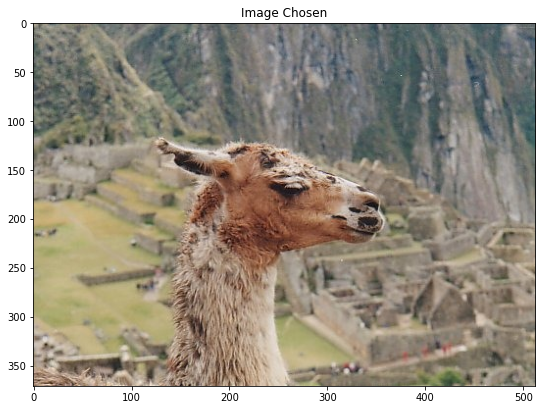

In [38]:
img = cv2.cvtColor(cv2.imread('../images/llama.jpg'), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
ax.imshow(img)
ax.title.set_text('Image Chosen')

Grabcut Ended......

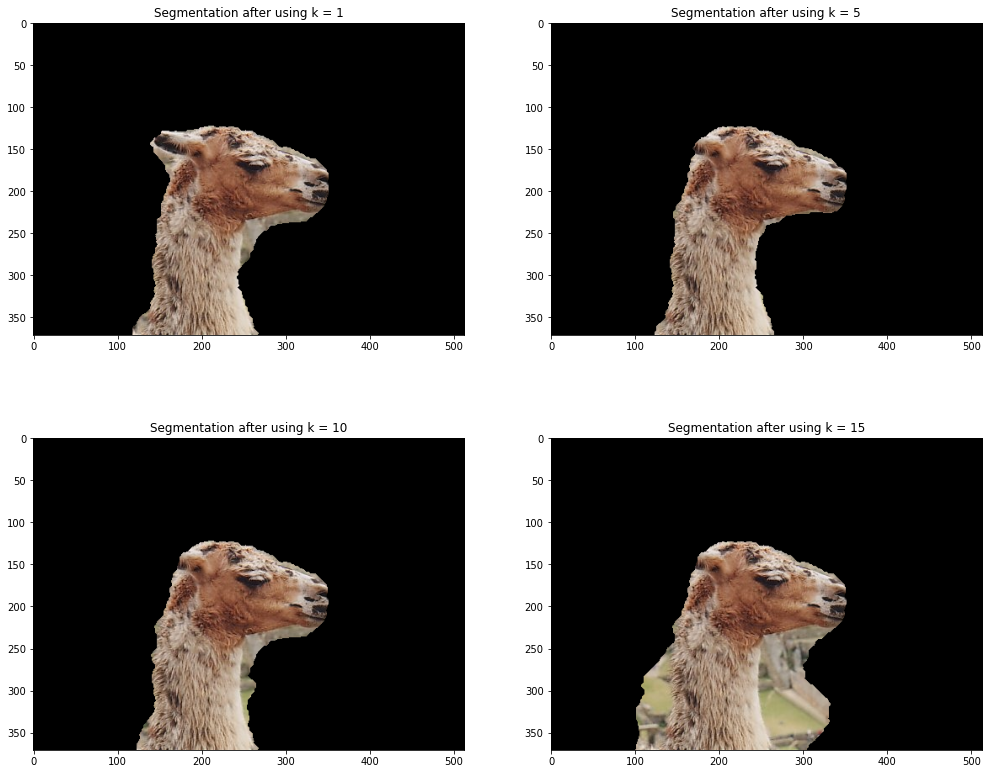

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 14))

img1 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=5, k=1)
imgl1 = cv2.bitwise_and(img, img, mask = np.where((img1[0] == 1), 255, 0).astype('uint8'))
img5 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=5, k=5)
imgl5 = cv2.bitwise_and(img, img, mask = np.where((img5[0] == 1), 255, 0).astype('uint8'))
img10 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=5, k=10)
imgl10 = cv2.bitwise_and(img, img, mask = np.where((img10[0] == 1), 255, 0).astype('uint8'))
img15 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=5, k=15)
imgl15 = cv2.bitwise_and(img, img, mask = np.where((img15[0] == 1), 255, 0).astype('uint8'))

ax[0][0].imshow(imgl1)
ax[0][0].title.set_text('Segmentation after using k = 1')
ax[0][1].imshow(imgl5)
ax[0][1].title.set_text('Segmentation after using k = 5')
ax[1][0].imshow(imgl10)
ax[1][0].title.set_text('Segmentation after using k = 10')
ax[1][1].imshow(imgl15)
ax[1][1].title.set_text('Segmentation after using k = 15')

We can see that we get a reasonable segmentation when the number of mixture components in GMM is set to 5. On increasing the value of k from there we see that the segmentation worsens.

### 2) The number of iterations of GMM updating and energy minimization.

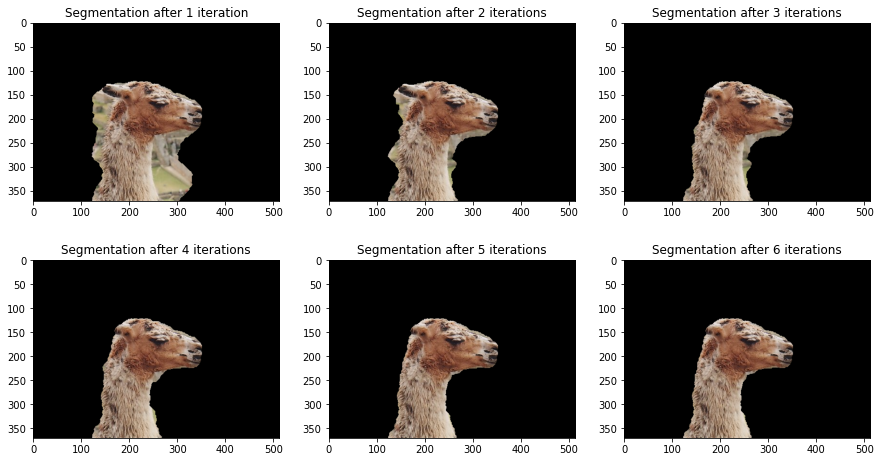

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

img1 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=1, k=5)
imgl1 = cv2.bitwise_and(img, img, mask = np.where((img1[0] == 1), 255, 0).astype('uint8'))
img2 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=2, k=5)
imgl2 = cv2.bitwise_and(img, img, mask = np.where((img2[0] == 1), 255, 0).astype('uint8'))
img3 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=3, k=5)
imgl3 = cv2.bitwise_and(img, img, mask = np.where((img3[0] == 1), 255, 0).astype('uint8'))
img4 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=4, k=5)
imgl4 = cv2.bitwise_and(img, img, mask = np.where((img4[0] == 1), 255, 0).astype('uint8'))
img5 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=5, k=5)
imgl5 = cv2.bitwise_and(img, img, mask = np.where((img5[0] == 1), 255, 0).astype('uint8'))
img6 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=6, k=5)
imgl6 = cv2.bitwise_and(img, img, mask = np.where((img6[0] == 1), 255, 0).astype('uint8'))

ax[0][0].imshow(imgl1)
ax[0][0].title.set_text('Segmentation after 1 iteration')
ax[0][1].imshow(imgl2)
ax[0][1].title.set_text('Segmentation after 2 iterations')
ax[0][2].imshow(imgl3)
ax[0][2].title.set_text('Segmentation after 3 iterations')
ax[1][0].imshow(imgl4)
ax[1][0].title.set_text('Segmentation after 4 iterations')
ax[1][1].imshow(imgl5)
ax[1][1].title.set_text('Segmentation after 5 iterations')
ax[1][2].imshow(imgl6)
ax[1][2].title.set_text('Segmentation after 6 iterations')

As the number of iterations increases, the segmentation tends to converge towards an optimal segmentation.

### 3) The choice of gamma.

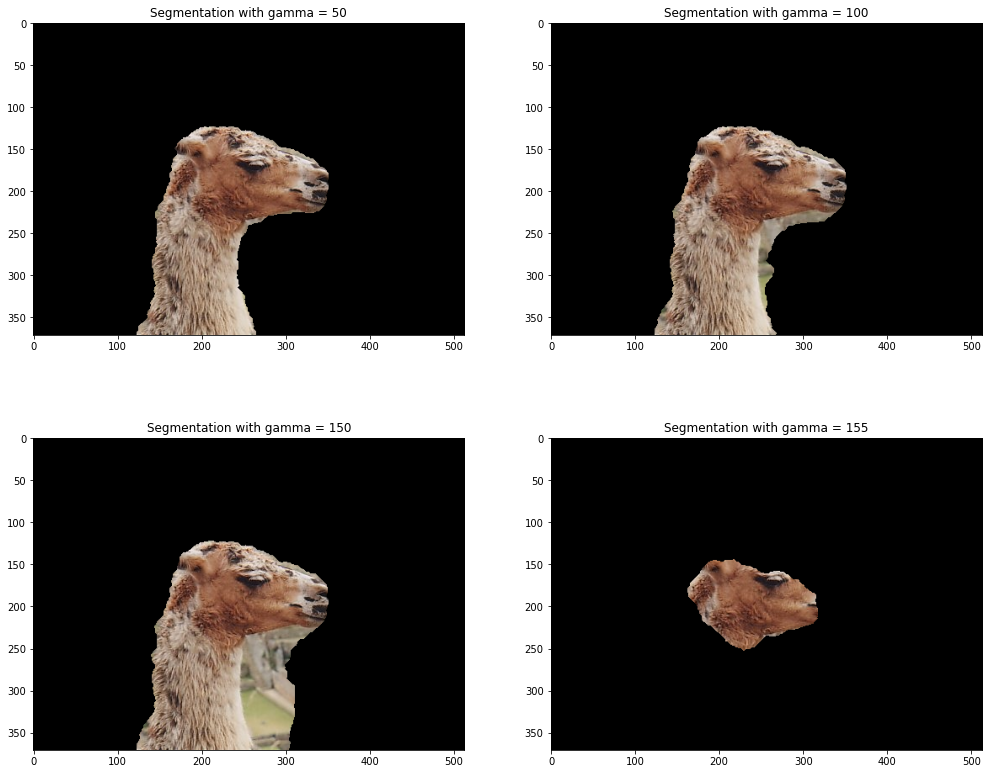

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 14))

img50 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 50, its=5, k=5)
imgl50 = cv2.bitwise_and(img, img, mask = np.where((img50[0] == 1), 255, 0).astype('uint8'))
img100 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 100, its=5, k=5)
imgl100 = cv2.bitwise_and(img, img, mask = np.where((img100[0] == 1), 255, 0).astype('uint8'))
img150 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 150, its=5, k=5)
imgl150 = cv2.bitwise_and(img, img, mask = np.where((img150[0] == 1), 255, 0).astype('uint8'))
img155 = grabCut(img, [100, 100, 250, 300], np.ones(img.shape[:2]), 155, its=5, k=5)
imgl155 = cv2.bitwise_and(img, img, mask = np.where((img175[0] == 1), 255, 0).astype('uint8'))

ax[0][0].imshow(imgl50)
ax[0][0].title.set_text('Segmentation with gamma = 50')
ax[0][1].imshow(imgl100)
ax[0][1].title.set_text('Segmentation with gamma = 100')
ax[1][0].imshow(imgl150)
ax[1][0].title.set_text('Segmentation with gamma = 150')
ax[1][1].imshow(imgl155)
ax[1][1].title.set_text('Segmentation with gamma = 155')

As gamma is increased, the segmentation becomes bad. At one point (gamma > 155) there are 0 samples in FG after min cut. We can see this trend visually too. The image disappears into a hole.